# Copyright Netherlands eScience Center <br>
**Function     : Testing BayesConvLSTM with Lorens-84 model** <br>
**Author       : Yang Liu** <br>
**First Built  : 2022.01.01** <br>
**Last Update  : 2022.01.01** <br>
**Library      : Pytorth, Numpy, NetCDF4, os, iris, cartopy, dlacs, matplotlib**<br>
Description     : This notebook serves to help understand the uncertainty generated by BayesConvLSTM with the sensitivity tests with Lorens 84 model. <br>

Three different types of uncertainties will vbe investigated here:<br>
- uncertainty of model outcome attributed to perturbation in initial conditions
- model uncertainty
- uncertainty related to extra/bias/trend terms

The Lorens-84 model is described by Edward Lorens in his 1984 paper:<br>
Lorenz, E. N. (1984). Irregularity: A fundamental property of the atmosphere. Tellus A, 36(2), 98-110.<br>

Return Values   : Time series and figures <br>

In [1]:
%matplotlib inline

import sys
import warnings
import numbers

# for data loading
import os
from netCDF4 import Dataset
# for pre-processing and machine learning
import numpy as np
#import sklearn
#import scipy
import torch
import torch.nn.functional

sys.path.append("/mnt/e/Creator_Zone/Script_craft/ML4Climate/Scripts/DLACs")
#sys.path.append("../")
import dlacs
import dlacs.BayesConvLSTM
import dlacs.preprocess
import dlacs.function
import dlacs.saveNetCDF

# for visualization
import dlacs.visual
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d import Axes3D

# ignore all the DeprecationWarnings by pytorch
if not sys.warnoptions:
    warnings.simplefilter("ignore")
###############################################################################

The testing device is Dell Inspirion 5680 with Intel Core i7-8700 x64 CPU and Nvidia GTX 1060 6GB GPU.<br>
Here is a benchmark about cpu v.s. gtx 1060 <br>
https://www.analyticsindiamag.com/deep-learning-tensorflow-benchmark-intel-i5-4210u-vs-geforce-nvidia-1060-6gb/

In [2]:
################################################################################# 
#########                           datapath                             ########
#################################################################################
# datapath for output
output_path = '/mnt/e/Creator_Zone/Script_craft/ML4Climate/PredictArctic/BayesMaps/Lorenz84/bayes/fullseries_ex/ultra_long_series/epoch3000_p100000_stdx16_layer3'
# datapath of trained bayesconvlstm model
model_path = '/mnt/e/Creator_Zone/Script_craft/ML4Climate/PredictArctic/BayesMaps/Lorenz84/bayes/fullseries_ex/ultra_long_series/epoch3000_p100000_stdx16_layer3'

In [3]:
if __name__=="__main__":
    #################################################################################
    ###########                configure Lorenz 84 model                  ###########
    #################################################################################
    # Lorenz paramters and initial conditions
    x_init = 1.0 # strength of the symmetric globally encircling westerly current
    y_init = 1.0 # strength of the cosine phases of a chain of superposedwaves (large scale eddies)
    z_init = 1.0 # strength of the sine phases of a chain of superposedwaves (large scale eddies)
    F = 8.0 # temperature difference between pole and equator
    G = 1.0 # thermal forcing term
    epsilon = 0.4 # intensity of periodic forcing
    a = 0.25 # mechanical damping factor for westerly wind x
    b = 4.0 # advection strength of the waves by the westerly current
    
    # assuming the damping time for the waves is 5 days (Lorens 1984)
    dt = 0.0333 # 1/30 unit of time unit (5 days) -> 1 time step represents 6 hours
    num_steps = 4200
    # cut-off point of initialization period
    cut_off = 0
    # target testing period
    test_len = 1800 # previously 450

#### Ensemble<br>
##### Testing benchmark <br>
- Lorenz 84 model initial set-up <br>
**x=1.0, y=1.0, z=1.0, a=0.25, b=4.0, F=8.0, G=1.0** <br>
**x=1.0, y=1.0, z=1.0, a=0.25, b=4.0, F=8.0, G=1.0, epsilon=0.4** <br>

##### Testing 
- Testing initial conditions x, y, z - uncertainty of model outcome <br>
**starting point x=1.0, y=1.0, z=1.0** <br>
Ensemble variant x 50 members <br>
x = [1.0020 : 0.9980] **~0.2%**<br>
x = [1.0010 : 0.9990] **~0.1%**<br>
x = [1.00010 : 0.99990] **~0.01%**<br>
x_ex = [1.0010 : 0.9990] **~0.1%**<br>
x_ex = [1.00010 : 0.99990] **~0.01%**<br>
x_ex = [1.000010 : 0.999990] **~0.001%**<br>
========================================================================================================<br>
- Testing model parameters a & b - model uncertainty <br>
**starting point a=0.25, b=4.0** <br>
Ensemble variant a <br>
a = [0.2501 : 0.24990] **~0.04%**<br>
========================================================================================================<br>
- Testing external forcing terms F & G - uncertainty related to extra/bias/trend terms <br>
**starting point F=8.0, G=1.0** <br>
Ensemble variant G <br>
G = [1.0010 : 0.9990] **~0.1%**<br>
**starting point F=8.0, G=1.0, epsilon=0.4** <br>

In [4]:
    #################################################################################
    ###########            Lorens 84 model + periodic forcing             ###########
    #################################################################################
    def lorenz84_ex(x, y, z, t, a = 0.25, b = 4.0, F = 8.0, G = 1.0, epsilon = 1.0):
        """
        Solver of Lorens-84 model with periodic external forcing.
        
        param x, y, z: location in a 3D space
        param a, b, F, G: constants and forcing
        
        The model is designed with a reference to the paper:
        Broer, H., Simó, C., & Vitolo, R. (2002). Bifurcations and strange
        attractors in the Lorenz-84 climate model with seasonal forcing. Nonlinearity, 15(4), 1205.
        
        Song, Y., Yu, Y., & Wang, H. (2011, October). The stability and chaos analysis of the
        Lorenz-84 atmosphere model with seasonal forcing. In 2011 Fourth International Workshop
        on Chaos-Fractals Theories and Applications (pp. 37-41). IEEE.
        """
        # each time step is ~ 5days, therefore the returning period are 365 / 5 = 73 times in a year
        T = 73
        omega = 2 * np.pi / T
        dx = - y**2 - z**2 - a * x + a * F * (1 + epsilon * np.cos(omega * t))
        dy = x * y - b * x * z - y + G * (1 + epsilon * np.sin(omega * t))
        dz = b * x * y + x * z - z
        
        return dx, dy, dz

In [5]:
    #################################################################################
    ###########        Launch Lorenz 84 model with periodic forcing       ###########
    #################################################################################   
    # Need one more for the initial values
    x = np.empty(num_steps)
    y = np.empty(num_steps)
    z = np.empty(num_steps)
    t = 0.0
    
    # save initial values
    x[0] = x_init
    y[0] = y_init
    z[0] = z_init
    
    # Step through "time", calculating the partial derivatives at the current point
    # and using them to estimate the next point
    for i in range(num_steps-1):
        dx, dy, dz = lorenz84_ex(x[i], y[i], z[i], t, a, b ,F, G, epsilon)
        x[i + 1] = x[i] + (dx * dt)
        y[i + 1] = y[i] + (dy * dt)
        z[i + 1] = z[i] + (dz * dt)
        t += dt

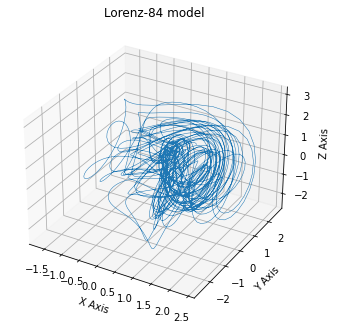

<Figure size 432x288 with 0 Axes>

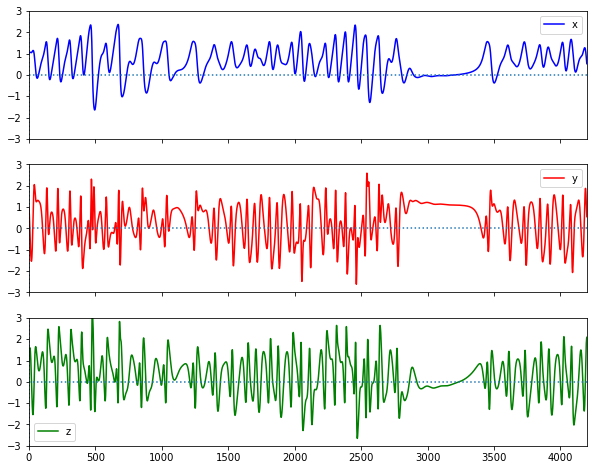

In [6]:
    #################################################################################
    ###########                 Visualize Lorens 84 model                    ###########
    #################################################################################   
    # save Lorens model output
    index = np.arange(num_steps)
    # Plot
    fig00 = plt.figure(figsize=(8,5.4))
    ax = fig00.gca(projection='3d')
    ax.plot(x, y, z, lw=0.5)
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    ax.set_title("Lorenz-84 model")
    plt.show()
        
    fig01 = plt.figure()
    fig01, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig01.set_size_inches(10, 8, forward=True)
    ax1.plot(index, x, 'b', label='x')
    ax2.plot(index, y, 'r', label='y')
    ax3.plot(index, z, 'g', label='z')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.axvline(x=cut_off, ls = ':')
    ax2.axvline(x=cut_off, ls = ':')
    ax3.axvline(x=cut_off, ls = ':')
    
    ax1.set_xlim(0, num_steps)
    ax2.set_xlim(0, num_steps)
    ax3.set_xlim(0, num_steps)
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)    
    
    ax1.legend()
    ax2.legend()
    ax3.legend()

    plt.show()

# Forecast with BayesConvLSTM <br>
** We use Pytorth to implement BayesConvLSTM neural network to deal with the Lorenz 84 model output. ** <br>

In [7]:
    print ('*******************  pre-processing  *********************')
    # time series cut-off
    if cut_off:
        x = x[cut_off:]
        y = y[cut_off:]
        z = z[cut_off:]
    print ('===================  normalize data  =====================')
    x_norm = dlacs.preprocess.operator.normalize(x)
    y_norm = dlacs.preprocess.operator.normalize(y)
    z_norm = dlacs.preprocess.operator.normalize(z)
    print('================  save the normalizing factor  =================')
    x_max = np.amax(x)
    x_min = np.amin(x)
    y_max = np.amax(y)
    y_min = np.amin(y)
    z_max = np.amax(z)
    z_min = np.amin(z)

*******************  pre-processing  *********************
===================  normalize data  =====================
================  save the normalizing factor  =================


In [8]:
    print ('*******************  create basic dimensions for tensor and network  *********************')
    # specifications of neural network
    input_channels = 3
    hidden_channels = [3, 3, 3] # number of channels & hidden layers, the channels of last layer is the channels of output, too
    #hidden_channels = [3, 3, 3, 3, 3]
    kernel_size = 1
    # here we input a sequence and predict the next step only
    #step = 1 # how many steps to predict ahead
    #effective_step = [0] # step to output
    batch_size = 1
    #num_layers = 1
    learning_rate = 0.0001
    num_epochs = 500
    # check the sequence shape
    sequence_len = num_steps - cut_off
    height = 1
    width = 1
    print ('*******************  testing data  *********************')
    test_len = 1800 # previously 450
    print ('*******************  check the environment  *********************')
    print ("Pytorch version {}".format(torch.__version__))
    # check if CUDA is available
    #use_cuda = torch.cuda.is_available()
    #print("Is CUDA available? {}".format(use_cuda))
    #logging.info("Is CUDA available? {}".format(use_cuda))
    # CUDA settings torch.__version__ must > 0.4
    # !!! This is important for the model!!! The first option is gpu
    #device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    device = torch.device("cpu")

*******************  create basic dimensions for tensor and network  *********************
*******************  testing data  *********************
*******************  check the environment  *********************
Pytorch version 1.10.1


In [9]:
    %%time
    print ('*******************  load exsited LSTM model  *********************')
    # load model parameters
    model = dlacs.BayesConvLSTM.BayesConvLSTM(input_channels, hidden_channels, kernel_size).to(device)
    #model = dlacs.BayesConvLSTM.BayesConvLSTM(input_channels, hidden_channels, kernel_size, cell_type="full").to(device)
    #model.load_state_dict(torch.load(os.path.join(model_path, 'bayesconvlstm_lorenz84_ex.pkl'),
    #                                 map_location=device))
    
    # load whole model state
    checkpoint = torch.load(os.path.join(model_path, 'base', 'epoch_2400_2800',
                            'bayesconvlstm_training_checkpoint_epoch_2400_2800.pt'))
    model.load_state_dict(checkpoint['model_state_dict'])   

*******************  load exsited LSTM model  *********************
!@#$% The network will be built with reduced size BayesConvLSTM cell. !@#$%
CPU times: user 11.7 ms, sys: 1.15 ms, total: 12.8 ms
Wall time: 49.3 ms


<All keys matched successfully>

In [10]:
    for name, param in model.named_parameters():
        if param.requires_grad:
            print (name)
            print (param.data)
            print (param.size())
            print ("=========================")

cell0.Wxi_mu
tensor([[[[ 1.7239e+00]],

         [[ 1.2590e+00]],

         [[ 6.3229e-01]]],


        [[[-5.4177e-01]],

         [[ 2.3486e+00]],

         [[ 1.4137e-03]]],


        [[[ 1.4276e+00]],

         [[-1.0598e-01]],

         [[-2.3861e-01]]]])
torch.Size([3, 3, 1, 1])
cell0.Whi_mu
tensor([[[[-0.1523]],

         [[-0.3252]],

         [[-0.9474]]],


        [[[ 0.5943]],

         [[ 0.4261]],

         [[ 1.5387]]],


        [[[-0.8939]],

         [[-0.2105]],

         [[-0.1123]]]])
torch.Size([3, 3, 1, 1])
cell0.Wxf_mu
tensor([[[[ 0.7474]],

         [[ 1.6316]],

         [[-3.7005]]],


        [[[-1.4188]],

         [[ 1.3943]],

         [[ 0.2236]]],


        [[[ 0.3092]],

         [[-0.1427]],

         [[-0.9106]]]])
torch.Size([3, 3, 1, 1])
cell0.Whf_mu
tensor([[[[ 2.5115]],

         [[-1.1182]],

         [[-1.9414]]],


        [[[ 0.3944]],

         [[-0.4428]],

         [[ 2.8065]]],


        [[[-1.0075]],

         [[-0.8851]],

         [[-0

In [11]:
    print('##############################################################')
    print('#############  preview model parameters matrix  ###############')
    print('##############################################################')
    print('Number of parameter matrices: ', len(list(model.parameters())))
    for i in range(len(list(model.parameters()))):
        print(list(model.parameters())[i].size())

##############################################################
#############  preview model parameters matrix  ###############
##############################################################
Number of parameter matrices:  60
torch.Size([3, 3, 1, 1])
torch.Size([3, 3, 1, 1])
torch.Size([3, 3, 1, 1])
torch.Size([3, 3, 1, 1])
torch.Size([3, 3, 1, 1])
torch.Size([3, 3, 1, 1])
torch.Size([3, 3, 1, 1])
torch.Size([3, 3, 1, 1])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([3, 3, 1, 1])
torch.Size([3, 3, 1, 1])
torch.Size([3, 3, 1, 1])
torch.Size([3, 3, 1, 1])
torch.Size([3, 3, 1, 1])
torch.Size([3, 3, 1, 1])
torch.Size([3, 3, 1, 1])
torch.Size([3, 3, 1, 1])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
t

# Forecast <br>
**Forecast loop and ensemble generation.** <br>

In [12]:
    %%time
    #################################################################################
    ########  operational lead time dependent prediction with testing data   ########
    #################################################################################
    print('##############################################################')
    print('###################  start prediction loop ###################')
    print('##############################################################')
    # the model learn from time series and try to predict the next time step based on the previous time series
    print ('*******************************  one step ahead forecast  *********************************')
    # time series before test data
    pred_base_x = x_norm[:-test_len]
    pred_base_y = y_norm[:-test_len]
    pred_base_z = z_norm[:-test_len]
    # predict x steps ahead
    step_lead = 60 # unit 4 hours
    # ensemble
    ensemble = 6
    # create a matrix for the prediction
    lead_pred_x = np.zeros((test_len,step_lead),dtype=float) # dim [predict time, lead time，lat, lon]
    lead_pred_y = np.zeros((test_len,step_lead),dtype=float) # dim [predict time, lead time，lat, lon]
    lead_pred_z = np.zeros((test_len,step_lead),dtype=float) # dim [predict time, lead time，lat, lon]
    # start the prediction loop
    for ens in range(ensemble):
        print('ensemble No. {}'.format(ens))
        ncKey = dlacs.saveNetCDF.savenc(output_path, 'pred_lorenz84_ens_{}_per1t.nc'.format(ens))
        lead_pred_xyz = np.zeros((3, test_len, step_lead), dtype=float)
        for step in range(test_len):
            # Clear stored gradient
            model.zero_grad()
            # Don't do this if you want your LSTM to be stateful
            # Otherwise the hidden state should be cleaned up at each time step for prediction (we don't clear hidden state in our forward function)
            # see example from (https://github.com/pytorch/examples/blob/master/time_sequence_prediction/train.py)
            # model.hidden = model.init_hidden()
            # based on the design of this module, the hidden states and cell states are initialized when the module is called.
            for i in np.arange(1,sequence_len - test_len + step + step_lead, 1): # here i is actually the time step (index) of prediction, we use var[:i] to predict var[i]
                #############################################################################
                ###############           before time of prediction           ###############
                #############################################################################
                if i <= (sequence_len - test_len + step):
                    # create variables
                    x_input = np.stack((x_norm[i-1], y_norm[i-1], z_norm[i-1])) #vstack,hstack,dstack
                    x_var_pred = torch.autograd.Variable(torch.Tensor(x_input).view(-1,input_channels,height,width),
                                                         requires_grad=False).to(device)
                    # make prediction
                    last_pred, _, _ = model(x_var_pred, i-1, training=False)
                    # record the real prediction after the time of prediction
                    if i == (sequence_len - test_len + step):
                        lead = 0
                        # GPU data should be transferred to CPU
                        lead_pred_x[step,0] = last_pred[0,0].cpu().data.numpy()
                        lead_pred_y[step,0] = last_pred[0,1].cpu().data.numpy()
                        lead_pred_z[step,0] = last_pred[0,2].cpu().data.numpy()
                #############################################################################
                ###############            after time of prediction           ###############
                #############################################################################
                else:
                    lead += 1
                    # use the predicted data to make new prediction
                    x_input = np.stack((lead_pred_x[step,i-(sequence_len - test_len + step +1)],
                                        lead_pred_y[step,i-(sequence_len - test_len + step +1)],
                                        lead_pred_z[step,i-(sequence_len - test_len + step +1)])) #vstack,hstack,dstack
                    x_var_pred = torch.autograd.Variable(torch.Tensor(x_input).view(-1,input_channels,height,width),
                                                         requires_grad=False).to(device)
                    # make prediction
                    last_pred, _, _ = model(x_var_pred, i-1, training=False)
                    # record the prediction
                    lead_pred_x[step,lead] = last_pred[0,0].cpu().data.numpy()
                    lead_pred_y[step,lead] = last_pred[0,1].cpu().data.numpy()
                    lead_pred_z[step,lead] = last_pred[0,2].cpu().data.numpy()
        lead_pred_xyz[0,:,:] = lead_pred_x[:]
        lead_pred_xyz[1,:,:] = lead_pred_y[:]
        lead_pred_xyz[2,:,:] = lead_pred_z[:]
        ncKey.ncfile_Lorenz(lead_pred_xyz)

##############################################################
###################  start prediction loop ###################
##############################################################
*******************************  one step ahead forecast  *********************************
ensemble No. 0
Save output fields as netCDF4 files.
Create netcdf files successfully!!
ensemble No. 1
Save output fields as netCDF4 files.
Create netcdf files successfully!!
ensemble No. 2
Save output fields as netCDF4 files.
Create netcdf files successfully!!
ensemble No. 3
Save output fields as netCDF4 files.
Create netcdf files successfully!!
ensemble No. 4
Save output fields as netCDF4 files.
Create netcdf files successfully!!
ensemble No. 5
Save output fields as netCDF4 files.
Create netcdf files successfully!!
CPU times: user 17h 19min 2s, sys: 3min 7s, total: 17h 22min 9s
Wall time: 17h 22min 4s
